- time from chemo

- boxplots
  - age
  - cesd
  - fact-cog
  - remake akkermansia
- within group beta div
  - boxplot
  - stat testing?
- taxa barplot
- alpha div depression stats testing

In [1]:
%cd /Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101


In [2]:
import pandas as pd
import numpy as np
from qiime2 import Artifact, Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kruskal
from scipy.optimize import curve_fit
%matplotlib inline

## Time from Chemo

#### Loading up, cleaning data

In [3]:
faith_pd = Artifact.load("core-diversity-results/faith_pd_vector.qza").view(pd.Series)
time_df = pd.read_csv("time-difference.txt", sep="\t", index_col="Study ID ")
metadata = pd.read_csv("Categorical-meta-noNA.tsv", sep="\t")

In [4]:
time_df.head()

,BC (1) HC (0),Psych Assessment Day,Stool Sample Day,date closest to assessment,date closest to stool,Diff tx to psych Assess,Diff tx to Stool,Unnamed: 8,Unnamed: 9,Psych difference,stool difference
Study ID,,,,,,,,,,,
1001,1,1/20/19,2/13/19,1/2/19,1/2/19,18.0,42.0,NaN,AVG,11.428571,13.000000
1011,1,12/18/18,7/9/19,12/27/18,6/12/19,-9.0,27.0,NaN,SD,11.271963,14.424681
1013,1,1/4/19,1/9/19,1/4/19,1/9/19,0.0,0.0,NaN,NaN,NaN,NaN
1017,1,3/5/19,3/27/19,2/26/19,3/18/19,7.0,9.0,NaN,NaN,NaN,NaN
1018,1,2/17/19,3/29/19,2/8/19,3/21/19,9.0,8.0,NaN,NaN,NaN,NaN


In [5]:
type(time_df.index)

pandas.core.indexes.numeric.Int64Index

In [6]:
faith_pd.index = faith_pd.index.astype(int)

In [7]:
metadata = metadata.iloc[:33]
metadata["StudyID"] = metadata["plate.sample.id"].apply(lambda x: str(x).replace(" ", "").split("-")[0])
metadata = metadata.set_index(metadata["StudyID"].astype(int))

In [8]:
metadata["Time difference"] = time_df["Diff tx to Stool "]

In [9]:
metadata = metadata[metadata["linkerprimersequence"].isna()==False]

In [10]:
metadata = metadata.set_index(metadata["sampleid"].astype(int))

In [11]:
mapper = {"1 - Yes": "Breast Cancer", "2 - No": "Healthy Control"}

metadata["Chemotherapy"] = metadata["hcvsbc-cat"].apply(lambda x: mapper[x])

In [12]:
time_faith = pd.concat([metadata[["Time difference","Chemotherapy"]], faith_pd], axis=1) 

#### Only grab the ones that aren't NA and where time diff is not negative

In [13]:
time_faith = time_faith[time_faith["Chemotherapy"].isna()==False]

In [14]:
time_faith = time_faith[(time_faith["Time difference"]>=0) | 
                        ((time_faith["Time difference"].isna()) & (time_faith["Chemotherapy"]=="Healthy Control"))]

In [15]:
time_faith["Time difference"] = time_faith["Time difference"].fillna(0)

#### Not very normal looking

<AxesSubplot:>

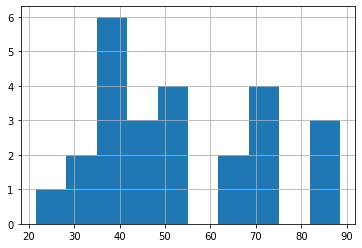

In [16]:
time_faith["faith_pd"].hist()

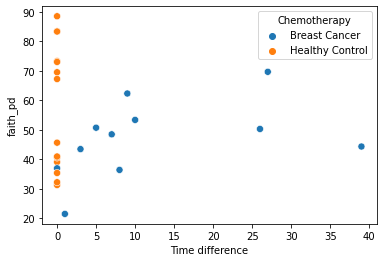

In [17]:
sns.scatterplot(y="faith_pd",
                x="Time difference",
                hue="Chemotherapy",
                data=time_faith,
                x_jitter=True,
                s=50)
plt.show()

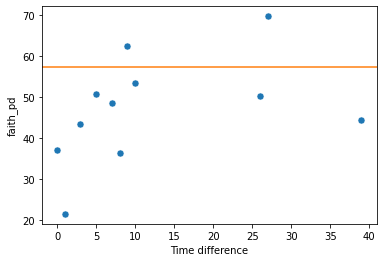

In [18]:
ax = sns.scatterplot(y="faith_pd",
                    x="Time difference",
                    data=time_faith[time_faith["Chemotherapy"]=="Breast Cancer"],
                    x_jitter=True,
                    s=50)
ax.axhline(time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean(),c="tab:orange")
plt.show()

In [19]:
time_faith_bc = time_faith[time_faith["Chemotherapy"]=="Breast Cancer"].dropna()

spearmanr(time_faith_bc["faith_pd"],
          time_faith_bc["Time difference"])

SpearmanrResult(correlation=0.5909090909090909, pvalue=0.05557560428877463)

In [20]:
time_faith

,Time difference,Chemotherapy,faith_pd
1,42.0,Breast Cancer,NaN
3,0.0,Healthy Control,39.137351
4,0.0,Healthy Control,83.452385
6,0.0,Healthy Control,45.691895
8,0.0,Healthy Control,31.343711
10,0.0,Healthy Control,67.279588
12,0.0,Healthy Control,40.645350
14,27.0,Breast Cancer,69.714897
15,0.0,Healthy Control,88.562366
17,0.0,Breast Cancer,37.002279


In [21]:
fit = np.polyfit(x = np.log(time_faith_bc["Time difference"]+0.01),
                 y = time_faith_bc["faith_pd"],
                 deg=1)

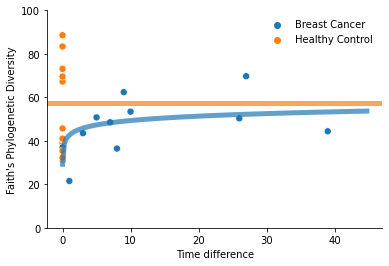

In [22]:
x = np.arange(0,45,0.25)+0.01
y = fit[0] * np.log(x) + fit[1]

ax = sns.scatterplot(y="faith_pd",
                     x="Time difference",
                     data=time_faith,
                     hue="Chemotherapy",
                     x_jitter=True,
                     s=50)
ax.axhline(time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean(),
           c="tab:orange",
           lw=5,
           alpha=0.7)

ax.plot(x,y, lw=5, alpha=0.7)
ax.set_ylim(0,100)
ax.set_ylabel("Faith's Phylogenetic Diversity")

plt.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.savefig("faith_time_logfit.pdf")
plt.show()

In [23]:
def func(x, a, b):
    return a * np.sqrt(x) + b
fit2 = curve_fit(func, 
                 xdata=time_faith_bc["Time difference"],
                 ydata=time_faith_bc["faith_pd"])

In [24]:
print(f'fit 1: {fit} \nfit 2: {fit2[0]}')

fit 1: [ 2.90910588 42.63093028] 
fit 2: [ 3.79120495 35.66804256]


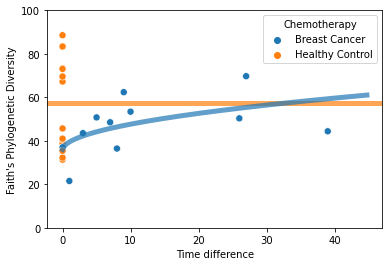

In [25]:
x = np.arange(0,45,0.25)+0.01
y = fit2[0][0] * np.sqrt(x) + fit2[0][1]

ax = sns.scatterplot(y="faith_pd",
                     x="Time difference",
                     data=time_faith,
                     hue="Chemotherapy",
                     x_jitter=True,
                     s=50)
ax.axhline(time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean(),
           c="tab:orange",
           lw=5,
           alpha=0.7)

ax.plot(x,y, lw=5, alpha=0.7)

ax.set_ylim(0,100)
ax.set_ylabel("Faith's Phylogenetic Diversity")

plt.savefig("faith_sqrt_fit.pdf")
plt.show()

In [26]:
grp_mapper = {"Breast Cancer": "Group 1", "Healthy Control": "Group 2"}
time_faith["Experimental Group"] = time_faith["Chemotherapy"].apply(lambda x: grp_mapper[x])

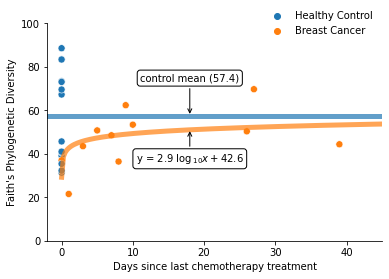

In [27]:
x = np.arange(0,45,0.25)+0.01
logy = fit[0] * np.log(x) + fit[1]


ax = sns.scatterplot(y="faith_pd",
                     x="Time difference",
                     data=time_faith,
                     hue="Chemotherapy", palette=["tab:orange", "tab:blue"],
                     x_jitter=True,
                     s=50)

ax.axhline(time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean(),
           c="tab:blue",
           lw=5,
           alpha=0.7)

ax.plot(x,logy, lw=5, alpha=0.7, c="tab:orange")



annot_coords = (18, fit[0] * np.log(20) + fit[1])

ax.annotate("y = " + str(round(fit[0],1)) + r" $\log{_{10}}{x} + $" + str(round(fit[1], 1)), 
            xy=annot_coords, xytext=(18, fit[0] * np.log(20) + fit[1]-15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

grp2_mean = time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean()

ax.annotate("control mean (" + str(round(grp2_mean,1)) + ")", 
            xy=(18, grp2_mean), 
            xytext=(18, grp2_mean + 16),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

ax.set_ylim(0,100)
ax.set_xlim(-2,45)
ax.set_ylabel("Faith's Phylogenetic Diversity")
ax.set_xlabel("Days since last chemotherapy treatment")

# flip legend order
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           frameon=False, bbox_to_anchor=(1,1.1))
# remove spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("faith_log_fit_annotated.pdf")
plt.show()

## Psych boxplots

In [28]:
updated_cesd = pd.read_csv("../CES-D range correction 3.7.22.csv", index_col="participant ID ")

In [29]:
metadata = metadata.set_index(["StudyID"])
metadata.index = [int(x) for x in metadata.index]
metadata["Updated CES-D"] = updated_cesd["CESD-total "]

In [30]:
melted_demo = pd.melt(metadata[["age","Updated CES-D", "fact_c_total", "Chemotherapy"]],
                       id_vars="Chemotherapy")

In [31]:
melted_demo["Experimental Group"] = melted_demo["Chemotherapy"].apply(lambda x: grp_mapper[x])

In [32]:
melted_demo.iloc[40:50]

,Chemotherapy,variable,value,Experimental Group
40,Breast Cancer,Updated CES-D,0.0,Group 1
41,Healthy Control,Updated CES-D,7.0,Group 2
42,Breast Cancer,Updated CES-D,13.0,Group 1
43,Healthy Control,Updated CES-D,0.0,Group 2
44,Breast Cancer,Updated CES-D,18.0,Group 1
45,Breast Cancer,Updated CES-D,19.0,Group 1
46,Breast Cancer,Updated CES-D,10.0,Group 1
47,Breast Cancer,Updated CES-D,2.0,Group 1
48,Breast Cancer,Updated CES-D,13.0,Group 1
49,Breast Cancer,Updated CES-D,12.0,Group 1


In [33]:
melted_demo["variable"].unique()

array(['age', 'Updated CES-D', 'fact_c_total'], dtype=object)

In [34]:
import matplotlib

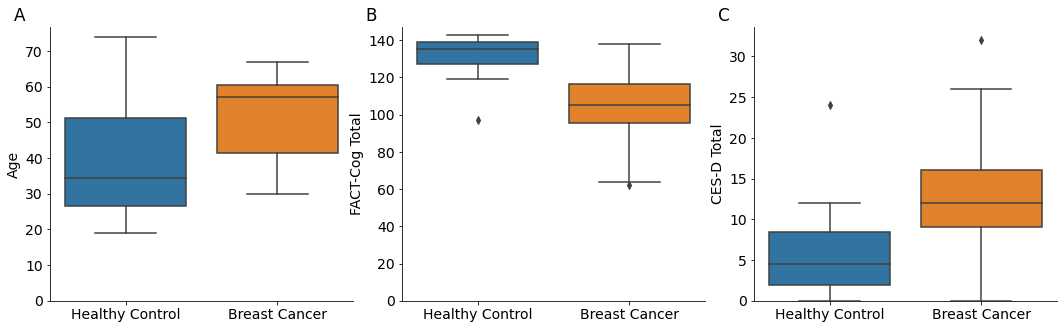

In [35]:
font = {'size'   : 14}

matplotlib.rc('font', **font)

g = sns.catplot(x="Chemotherapy",
            y="value",
            data=melted_demo,
            col="variable",
            kind="box",
            palette=["tab:blue", "tab:orange"],
            sharey=False,
            order=["Healthy Control", "Breast Cancer"],
            col_order=["age", "fact_c_total", "Updated CES-D"])


g.axes.flatten()[0].set_ylabel("Age")
g.axes.flatten()[1].set_ylabel("FACT-Cog Total")
g.axes.flatten()[2].set_ylabel("CES-D Total")

g.axes.flatten()[0].set_title("A",x=-0.1)
g.axes.flatten()[1].set_title("B",x=-0.1)
g.axes.flatten()[2].set_title("C",x=-0.1)

for ax in g.axes.flatten():
    #ax.set_title("")
    ax.set_ylim(0,)
    ax.set_xlabel("")
    
plt.savefig("reanalysis-2/Figures/age-cesd-fact-boxplots.pdf")
plt.savefig("reanalysis-2/Figures/age-cesd-fact-boxplots.png")
plt.show()

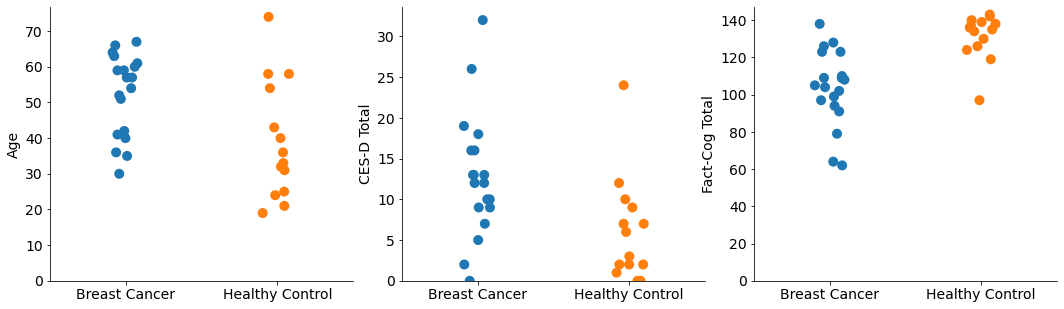

In [36]:
g = sns.catplot(x="Chemotherapy",
            y="value",
            data=melted_demo,
            col="variable",
            s=10,
            sharey=False)

g.axes.flatten()[0].set_ylabel("Age")
g.axes.flatten()[1].set_ylabel("CES-D Total")
g.axes.flatten()[2].set_ylabel("Fact-Cog Total")

for ax in g.axes.flatten():
    ax.set_title("")
    ax.set_ylim(0,)
    ax.set_xlabel("")
    

## *Akkermansia* plots

In [39]:
metadata = metadata.reset_index().set_index("sampleid")
metadata["StudyID"] = metadata["index"]

In [40]:
tax_table = Artifact.load("tax-L6-table.qza").view(pd.DataFrame)

In [41]:
tax_mat = np.matrix(tax_table)
tax_mat /= np.sum(tax_mat, axis=1)
tax_table = pd.DataFrame(tax_mat, 
                         index=[int(ind) for ind in tax_table.index], 
                         columns=tax_table.columns)

In [42]:
akkermansia = [col for col in tax_table.columns if "Akkermansia" in col]

In [43]:
akkermansia_chemo = pd.concat([tax_table[akkermansia],
                               metadata["Chemotherapy"]],
                              axis=1).dropna()
akkermansia_chemo["Experimental Group"] = akkermansia_chemo["Chemotherapy"].apply(lambda x: grp_mapper[x])

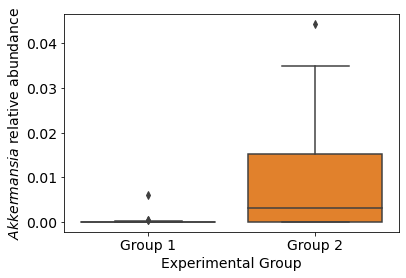

In [44]:
p = sns.boxplot(x="Experimental Group",
                y=akkermansia[0],
                data=akkermansia_chemo)
p.set_ylabel(r"$Akkermansia$ relative abundance")

plt.savefig("Akkermansia-boxplots.pdf")
plt.show()

In [45]:
akkermansia_time = pd.concat([tax_table[akkermansia],
                               metadata["Time difference"]],
                              axis=1).dropna()
akkermansia_time = akkermansia_time[akkermansia_time["Time difference"] >= 0]

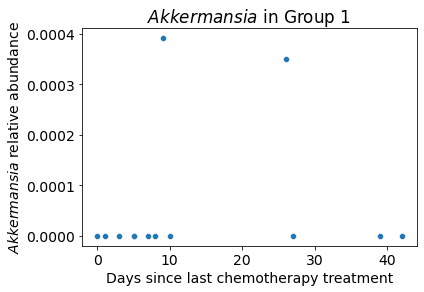

In [46]:
p = sns.scatterplot(x="Time difference",
                y=akkermansia[0],
                data=akkermansia_time)
p.set_ylabel(r"$Akkermansia$ relative abundance")
p.set_xlabel(r"Days since last chemotherapy treatment")
p.set_title(r"$Akkermansia$ in Group 1")

plt.savefig("akkermansia-time.pdf")
plt.show()

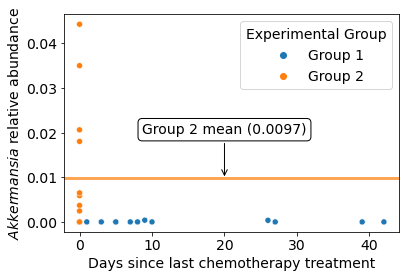

In [47]:
akkermansia_time_all = pd.concat([tax_table[akkermansia],
                                  metadata[["Chemotherapy","Time difference"]]], 
                                 axis=1)
akkermansia_time_all = akkermansia_time_all[(akkermansia_time_all["Time difference"] >= 0) | 
                                            (akkermansia_time_all["Chemotherapy"]=="Healthy Control")]

akkermansia_time_all["Experimental Group"] = akkermansia_time_all["Chemotherapy"].apply(lambda x: grp_mapper[x])
akkermansia_time_all.fillna(0,inplace=True)

p = sns.scatterplot(x="Time difference",
                    y=akkermansia[0],
                    hue="Experimental Group",
                data=akkermansia_time_all)
grp2_akk_mean = akkermansia_time_all[akkermansia_time_all["Experimental Group"]=="Group 2"][akkermansia[0]].mean()
p.axhline(grp2_akk_mean,
          c="tab:orange", lw="3", alpha=0.7)

p.annotate("Group 2 mean (" + str(round(grp2_akk_mean,4)) + ")", 
            xy=(20, grp2_akk_mean), 
            xytext=(20, grp2_akk_mean + 0.01),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

p.set_ylabel(r"$Akkermansia$ relative abundance")
p.set_xlabel(r"Days since last chemotherapy treatment")

plt.savefig("akkermansia-time-all.pdf")
plt.show()

In [48]:
spearmanr(akkermansia_time["Time difference"],
          akkermansia_time[akkermansia[0]])

SpearmanrResult(correlation=0.21869328378394914, pvalue=0.47286762074199706)

## Depression alpha diversity

In [49]:
metadata["updated_cesd_total_categorical"] = metadata["Updated CES-D"].apply(lambda x: "depressive symptomatology" if x>=16 else "no depression")

In [50]:
chemo_cesd_faith = pd.concat([metadata[["updated_cesd_total_categorical", "Chemotherapy", "Updated CES-D"]],
                              faith_pd], 
                             axis=1).dropna()
chemo_cesd_faith["Experimental Group"] = chemo_cesd_faith["Chemotherapy"].apply(lambda x: grp_mapper[x])

<AxesSubplot:xlabel='Chemotherapy', ylabel='faith_pd'>

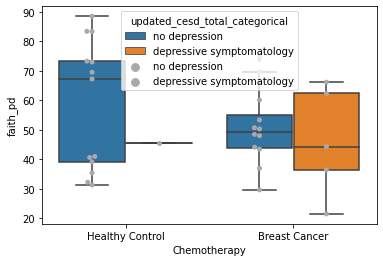

In [51]:
font = {'size'   : 10}

matplotlib.rc('font', **font)

ax = sns.boxplot(y="faith_pd",
            x="Chemotherapy",
            hue="updated_cesd_total_categorical",
            data=chemo_cesd_faith)

sns.swarmplot(y="faith_pd",
            x="Chemotherapy",
            hue="updated_cesd_total_categorical",
            dodge=True,
            palette=["darkgrey"],
            data=chemo_cesd_faith,
            ax=ax)

<AxesSubplot:>

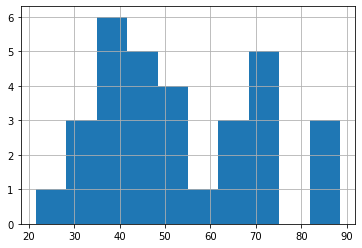

In [52]:
chemo_cesd_faith["faith_pd"].hist()

**Spearman with new CES-D scores and Faith PD**

In [53]:
spearmanr(chemo_cesd_faith["Updated CES-D"], chemo_cesd_faith["faith_pd"])

SpearmanrResult(correlation=-0.3260204106740875, pvalue=0.0734739651654051)

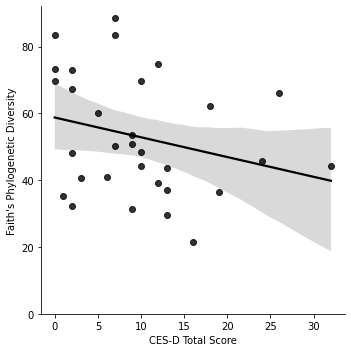

In [54]:
ax = sns.lmplot(x="Updated CES-D", y="faith_pd", data=chemo_cesd_faith, 
               line_kws={'color': 'black'}, scatter_kws={"color":"black"})
ax.set(ylim=0,ylabel="Faith's Phylogenetic Diversity", xlabel="CES-D Total Score")
plt.savefig("reanalysis-2/Figures/faith-cesd.pdf")
plt.savefig("reanalysis-2/Figures/faith-cesd.png")

plt.show()



## PERMDISP

In [ ]:
! qiime diversity core-metrics-phylogenetic \
--i-table table_noNA.qza \
--i-phylogeny insertion-tree.qza \
--p-sampling-depth 13100 \
--m-metadata-file Categorical-meta-noNA.tsv \
--output-dir core-diversity-results-noNA

In [ ]:
! qiime diversity beta-group-significance \
--i-distance-matrix core-diversity-results-noNA/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--m-metadata-column hcvsbc-cat \
--p-method permdisp \
--o-visualization core-diversity-results-noNA/permdisp_hcvsbc_ununi.qzv

#### Unweighted Unifrac
#### F value	2.06044
#### p-value	0.158

In [251]:
! qiime diversity beta-group-significance \
--i-distance-matrix core-diversity-results-noNA/weighted_unifrac_distance_matrix.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--m-metadata-column hcvsbc-cat \
--p-method permdisp \
--o-visualization core-diversity-results-noNA/permdisp_hcvsbc_wuni.qzv

Saved Visualization to: core-diversity-results-noNA/permdisp_hcvsbc_wuni.qzv


#### Weighted UniFrac
#### test statistic	1.22936
#### p-value	0.253

## Desulfobacterota

In [95]:
L2 = Artifact.load("reanalysis-2/L2-nobloom-table.qza").view(pd.DataFrame)
L2.index = L2.index.astype(int)

In [96]:
L2mat = np.matrix(L2) 
L2mat /= np.sum(L2mat, axis=1)
L2 = pd.DataFrame(L2mat, index = L2.index, columns=L2.columns)

## Taxa barplot remaking

In [98]:
metadata["Experimental Group"] = metadata["Chemotherapy"].apply(lambda x: grp_mapper[x])

In [102]:
metadata["sampleid"] = metadata.reset_index()["sampleid"].astype(int)

In [ ]:
metadata.to_csv("expr-group-metadata.tsv", sep="\t", index=False)

In [180]:
! qiime feature-table filter-samples \
--i-table noMito_noChloro-noNA-table.qza \
--m-metadata-file expr-group-metadata.tsv \
--o-filtered-table noMito_noChloro-expr-table.qza

Saved FeatureTable[Frequency] to: noMito_noChloro-expr-table.qza


In [181]:
! qiime taxa barplot \
--i-table noMito_noChloro-noNA-table.qza \
--i-taxonomy taxonomy-silva.qza \
--m-metadata-file expr-group-metadata.tsv \
--o-visualization expr-grp-taxa-barplot.qza

Saved Visualization to: expr-grp-taxa-barplot.qza.qzv


## PCoA nicer plots

In [103]:
from skbio.stats.ordination import OrdinationResults

In [104]:
u_uni_pcoa = Artifact.load("core-diversity-results-noNA/unweighted_unifrac_pcoa_results.qza").view(OrdinationResults)

In [105]:
u_uni_pcoa.proportion_explained.head()

0    0.124638
1    0.064752
2    0.061258
3    0.056244
4    0.049513
dtype: float64

In [106]:
u_uni_pcoa.samples.index = [int(x) for x in u_uni_pcoa.samples.index]
pcoa_df = pd.concat([u_uni_pcoa.samples,
                     metadata], axis=1)

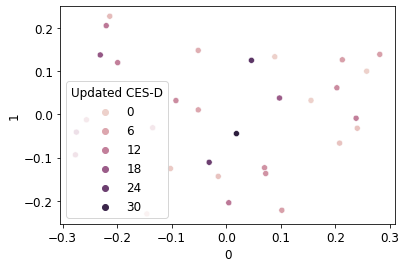

In [107]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

ax = sns.scatterplot(x=0, y=1, hue="Updated CES-D", 
                     data=pcoa_df)

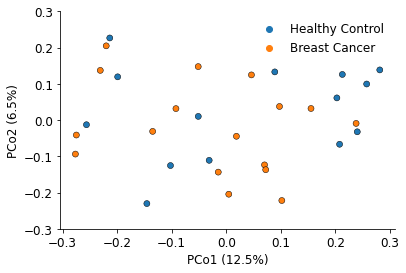

In [111]:
matplotlib.rc('font', **font)

ax = sns.scatterplot(x=0, y=1, hue="Chemotherapy", hue_order=["Healthy Control", "Breast Cancer"],
                     edgecolor="black",
                     data=pcoa_df)
handles, labels = ax.get_legend_handles_labels()

plt.clf() # Kinda hacky to get rid of the old plot but still have handles/labels

ax = sns.scatterplot(x=0, y=1, hue="Chemotherapy", hue_order=["Healthy Control", "Breast Cancer"],
                     edgecolor='black',
                     data=pcoa_df, legend=False)

ax.legend(handles=handles, labels=labels, title=None, frameon=False)

ax.set(ylim=(-0.3,0.3), ylabel="PCo2 (6.5%)", xlabel="PCo1 (12.5%)")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("reanalysis-2/Figures/HC-BC-PCoA-final.pdf")
plt.savefig("reanalysis-2/Figures/HC-BC-PCoA-final.png")
plt.show()


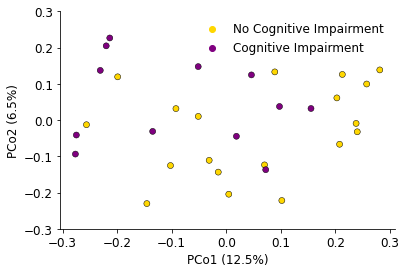

In [112]:
matplotlib.rc('font', **font)

ax = sns.scatterplot(x=0, y=1, hue="fact_c_r_imp_total_categorical", 
                     hue_order=["No Cognitive Impairment", "Cognitive Impairment"],
                     palette=["gold", "purple"],
                     data=pcoa_df)
handles, labels = ax.get_legend_handles_labels()

plt.clf() # Kinda hacky to get rid of the old plot but still have handles/labels

ax = sns.scatterplot(x=0, y=1, hue="fact_c_r_imp_total_categorical", 
                     hue_order=["No Cognitive Impairment", "Cognitive Impairment"],
                     palette=["gold", "purple"], 
                     edgecolor='black',
                     data=pcoa_df, legend=False)

ax.legend(handles=handles, labels=labels, title=None, frameon=False)

ax.set(ylim=(-0.3,0.3), ylabel="PCo2 (6.5%)", xlabel="PCo1 (12.5%)")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("reanalysis-2/Figures/FACT-Cog-PCoA-final.pdf")
plt.savefig("reanalysis-2/Figures/FACT-Cog-PCoA-final.png")

plt.show()


## Phyla corr with updated CESD

In [114]:
from skbio.stats.composition import clr

In [115]:
print("SPEARMAN CORR PHYLA AND CESD")
for col in L2.columns:
    r, p = spearmanr(metadata["Updated CES-D"].reindex_like(L2),
                      L2[col],
                    nan_policy="omit")
    
    if p < 0.05:
        print("SIGNIFICANT:")
    print(col, r, p)

SPEARMAN CORR PHYLA AND CESD
k__Archaea;p__Euryarchaeota -0.01015128340637748 0.9560261617495794
k__Bacteria;__ -0.12212910544570652 0.5054882221449815
k__Bacteria;p__ 0.024747248171400497 0.8930528704043305
k__Bacteria;p__Actinobacteria -0.06617675682050146 0.7189569259348045
k__Bacteria;p__Bacteroidetes 0.17922871638885812 0.32634091213596716
k__Bacteria;p__Cyanobacteria -0.18449287036254375 0.3120940688049905
k__Bacteria;p__Firmicutes -0.12022110822391098 0.5122105545347095
k__Bacteria;p__Fusobacteria 0.01730117350035964 0.9251224841534181
k__Bacteria;p__Lentisphaerae -0.15735673897321603 0.3897308401166224
k__Bacteria;p__Proteobacteria 0.06488998654899171 0.7242075925369261
k__Bacteria;p__Synergistetes -0.1414754187497763 0.4399001176720795
SIGNIFICANT:
k__Bacteria;p__Tenericutes -0.5326848122216936 0.0016973120003883895
k__Bacteria;p__Verrucomicrobia -0.1977932102848612 0.277861248481561


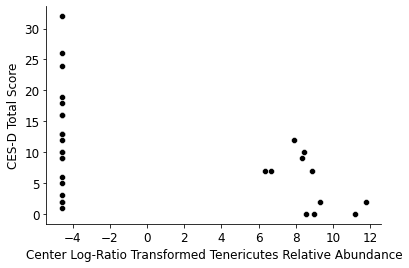

In [118]:
font = {'size'   : 12}
matplotlib.rc('font', **font)

ax = sns.scatterplot(x=clr(L2["k__Bacteria;p__Tenericutes"].apply(lambda x: x+0.00000001)),
                    y=metadata["Updated CES-D"].reindex_like(L2),
                    color=["black"])

ax.set(xlabel="Center Log-Ratio Transformed Tenericutes Relative Abundance",
       ylabel="CES-D Total Score")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#plt.savefig("reanalysis-2/Figures/FACT-Cog-PCoA-final.pdf")
#plt.savefig("reanalysis-2/Figures/FACT-Cog-PCoA-final.png")


plt.show()

## Point estimates

In [298]:
faith_pd.index = [float(x) for x in faith_pd.index]

In [304]:
metadata["faith"] = faith_pd

In [306]:
metadata.loc[metadata["Chemotherapy"]=="Breast Cancer", "faith"].mean()

49.46883630886542

In [ ]:
metadata.loc[metadata["Chemotherapy"]=="Breast Cancer", "faith"].mean()

In [307]:
metadata.loc[metadata["Chemotherapy"]=="Healthy Control", "faith"].mean()

57.442069505244206

In [313]:
faith_stats = metadata.groupby(["Chemotherapy"])["faith"].agg(["mean", "count","std"])
print(faith_stats)

for i in faith_stats.index:
    m, c, s = faith_stats.loc[i]
    hi = (m + 1.96*s/np.sqrt(c))
    lo = (m - 1.96*s/np.sqrt(c))
    
    print(f"{i}: {lo} - {hi}")


                      mean  count        std
Chemotherapy                                
Breast Cancer    49.468836     17  14.172454
Healthy Control  57.442070     14  21.273813
Breast Cancer: 42.731679143735654 - 56.205993473995186
Healthy Control: 46.29816489592784 - 68.58597411456057


In [316]:
L2_floatindex = L2
L2_floatindex.index = [float(x) for x in L2.index]

In [321]:
L2_meta = pd.concat([L2_floatindex, metadata["Chemotherapy"]],
                   axis=1)

In [323]:
tener_stats = L2_meta.groupby(["Chemotherapy"])["k__Bacteria;p__Tenericutes"].agg(["mean", "count","std"])
print(tener_stats)

for i in tener_stats.index:
    m, c, s = tener_stats.loc[i]
    hi = (m + 1.96*s/np.sqrt(c))
    lo = (m - 1.96*s/np.sqrt(c))
    
    print(f"{i}: {lo} - {hi}")

                     mean  count       std
Chemotherapy                              
Breast Cancer    0.000831     18  0.002003
Healthy Control  0.016034     14  0.036840
Breast Cancer: -9.445740230819353e-05 - 0.0017557712658621005
Healthy Control: -0.003263785750794647 - 0.035332488374026194


In [325]:
ver_stats = L2_meta.groupby(["Chemotherapy"])["k__Bacteria;p__Verrucomicrobia"].agg(["mean", "count","std"])
print(ver_stats)

for i in ver_stats.index:
    m, c, s = ver_stats.loc[i]
    hi = (m + 1.96*s/np.sqrt(c))
    lo = (m - 1.96*s/np.sqrt(c))
    
    print(f"{i}: {lo} - {hi}")

                     mean  count       std
Chemotherapy                              
Breast Cancer    0.000495     18  0.001550
Healthy Control  0.017141     14  0.033442
Breast Cancer: -0.00022157823068627536 - 0.0012107848274503581
Healthy Control: -0.0003768005562235152 - 0.034659254314975234


In [38]:
metadata.to_csv("metadata-updated-CESD.tsv", index=True, sep="\t")